In [ ]:
!pip install transformers
!pip install tensorflow_addons

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 895 kB 39.0 MB/s 
     |████████████████████████████████| 67 kB 3.5 MB/s 
     |████████████████████████████████| 6.8 MB 43.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
from google.colab import drive
import pickle
from transformers import BertTokenizer, TFAutoModel, AlbertTokenizerFast, TFBertModel
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_loc = './drive/MyDrive/'

with open(f'{drive_loc}/Compiled_Labeled_Data_Final.pkl', 'rb' ) as f:
  training_data = pickle.load(f)

In [ ]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

max_len = 512

entity_diction = { "Reason":2,
  "Defendant":1,
  "Penalties":3,
  "Outcome":4,
  "Platiff":0
}

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:

example = training_data[2]

def labeling_to_output(train):

  text = train[0]
  tokens = train[1]
  stringer = tokenizer.tokenize(text)
  tok = tokenizer(
                  text,
                  max_length = max_len, #change this for padding
                  truncation=True,
                  padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np'

  )

  output = np.zeros((len(tok['attention_mask'][0]), len(entity_diction)))

  for tag in tokens['entities']:
    start = tag[0]
    end = tag[1]
    tager = tag[2]

    before = tokenizer(text[:start], return_tensors='np')
    after = tokenizer(text[start:+end], return_tensors='np')

    starter = len(before['input_ids'][0]) - 1
    afterer = len(after['input_ids'][0]) - 1

    output[starter:(starter+afterer-1), entity_diction[tager]] = 1

  return tok, output

def get_entities(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }

  for i in range(1, len(output)):
      word = text[i]
      for n in range(5):
          open = entity_loc[n][1]
          val = output[i, n]
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

def get_entities_altered(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    1:["Defendant", False, []],
    0:["Plantiff",False, []],
    3:["Outcome", False, []],
  }

  for i in range(1, len(output)):
      word = text[i]
      for n in range(3):
          open = entity_loc[n][1]
          val = output[i, n]
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified


def get_entities_argmax(text, out, prob):
  
  new_out = []

  for i in range(len(out)):
      new = np.zeros(len(out[i]))
      maxer = out[i].argmax()
      new[maxer] = 1
      new_out.append(new.tolist())
  
  output = np.array(new_out)
  
  identified = []

  entity_loc = {
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }
  
  for i in range(1, len(output)):
      word = text[i]
      for n in range(5):
          open = entity_loc[n][1]
          try:
            val = output[i, n]
          except:
            pdb.set_trace()
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

def get_entities_argmax_altered(text, out, prob):
  
  new_out = []

  for i in range(len(out)):
      new = np.zeros(len(out[i]))
      maxer = out[i].argmax()
      new[maxer] = 1
      new_out.append(new.tolist())
  
  output = np.array(new_out)
  
  identified = []

  entity_loc = { 
    0:["Reason", False, []],
    1:["Outcome",False, []],
  }
  
  for i in range(1, len(output)):
      word = text[i]
      for n in range(2):
          open = entity_loc[n][1]
          try:
            val = output[i, n]
          except:
            pdb.set_trace()
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified  

In [ ]:
import pdb
def get_entities_argmax_running(text, out, run):
  
  new_out = []

  for i in range(len(out)):
      new = np.zeros(len(out[i]))
      maxer = out[i].argmax()
      new[maxer] = 1
      new_out.append(new.tolist())
  
  output = np.array(new_out)
  
  identified = []

  entity_loc = { 
    0:["Reason", False, []],
    1:["Outcome",False, []],
  }
  
  pdb.set_trace()

  return identified

In [ ]:
"""
import pdb
example = training_data[2]

entity_loc_len = { 
    2:1000,
    1:1000,
    3:1000,
    4:1000,
    0:1000
  }

def labeling_to_output(train):

  text = train[0]
  tokens = train[1]
  stringer = tokenizer.tokenize(text)
  tok = tokenizer(
                  text,
                  max_length = max_len, #change this for padding
                  truncation=True,
                  padding='max_length',
                  add_special_tokens=True,
                  return_tensors='np'

  )

  output = np.zeros((len(tok['attention_mask'][0]), len(entity_diction)*3))
  
  for tag in tokens['entities']:
    start = tag[0]
    end = tag[1]
    tager = tag[2]

    before = tokenizer(text[:start], return_tensors='np')
    after = tokenizer(text[start:+end], return_tensors='np')

    starter = len(before['input_ids'][0]) - 1
    afterer = len(after['input_ids'][0]) - 1
    if (starter+afterer) < max_len:
      output[starter:(starter+afterer-1), entity_diction[tager]] = 1
      output[starter, (entity_diction[tager]+len(entity_diction))] = 1
      output[(starter+afterer-2), int((entity_diction[tager]+len(entity_diction)*2))] = 1
    

  return tok, output


def get_entities(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }

  for i in range(1, len(output)):
      word = text[i]
      for n in range(5):
          open = entity_loc[n][1]
          val = output[i, n]
          if open == True:
              if val == 1:
                  entity_loc[n][2].append(word)
              else:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
          else:
              if val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True

  return identified

def get_entities_start_finish(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    2:["Reason", False, []],
    1:["Defendant",False, []],
    3:["Penalties", False, []],
    4:["Outcome", False, []],
    0:["Platiff", False, []]
  }
  
  for i in range(1, len(output)):
      word = text[i]
      
      for n in range(5):
          open = entity_loc[n][1]
          val = output[i, n]
          start_val = output[i, int(n+len(entity_diction))]
          end_val = output[i, int(n+len(entity_diction)*2)]

          if open == True:
                entity_loc[n][2].append(word)
                
                if end_val == 1:
                  entity_loc[n][1] = False
                  identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
                else:
                  if len(entity_loc[n][2]) > entity_loc_len[n]:
                      entity_loc[n][1] = False
                      entity_loc[n][2] = []
          else:
              if start_val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][1] = True
                  if end_val == 1:
                    entity_loc[n][1] = False
                    identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                    entity_loc[n][2] = []
                    

  return identified

def get_entities_start_finish_2(text, output, prob):

  output[output> prob] = 1
  output[output<= prob] = 0

  identified = []

  entity_loc = { 
    2:["Reason", False, [], []],
    1:["Defendant",False, [], []],
    3:["Penalties", False, [], []],
    4:["Outcome", False, [], []],
    0:["Platiff", False, [], []]
  }
  
  for i in range(1, len(output)):
      word = text[i]
      
      for n in range(5):
          open = entity_loc[n][1]
          val = output[i, n]
          start_val = output[i, int(n+len(entity_diction))]
          end_val = output[i, int(n+len(entity_diction)*2)]

          if open == True:
                entity_loc[n][2].append(word)
                entity_loc[n][3].append(val)
                
                if end_val == 1:
                  entity_loc[n][1] = False
                  if np.array(entity_loc[n][3]).mean() > 0.3:
                    identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                  entity_loc[n][2] = []
                  entity_loc[n][3] = []
                else:
                  if len(entity_loc[n][2]) > entity_loc_len[n]:
                      entity_loc[n][1] = False
                      entity_loc[n][2] = []
                      entity_loc[n][3] = []
          else:
              if start_val == 1:
                  entity_loc[n][2].append(word)
                  entity_loc[n][3].append(val)
                  entity_loc[n][1] = True
                  if end_val == 1:
                    entity_loc[n][1] = False
                    if np.array(entity_loc[n][3]).mean() > 0.3:
                      identified.append([entity_loc[n][0], tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(entity_loc[n][2]))])
                    entity_loc[n][2] = []
                    entity_loc[n][3] = []
                    

  return identified
"""

'\nimport pdb\nexample = training_data[2]\n\nentity_loc_len = { \n    2:1000,\n    1:1000,\n    3:1000,\n    4:1000,\n    0:1000\n  }\n\ndef labeling_to_output(train):\n\n  text = train[0]\n  tokens = train[1]\n  stringer = tokenizer.tokenize(text)\n  tok = tokenizer(\n                  text,\n                  max_length = max_len, #change this for padding\n                  truncation=True,\n                  padding=\'max_length\',\n                  add_special_tokens=True,\n                  return_tensors=\'np\'\n\n  )\n\n  output = np.zeros((len(tok[\'attention_mask\'][0]), len(entity_diction)*3))\n  \n  for tag in tokens[\'entities\']:\n    start = tag[0]\n    end = tag[1]\n    tager = tag[2]\n\n    before = tokenizer(text[:start], return_tensors=\'np\')\n    after = tokenizer(text[start:+end], return_tensors=\'np\')\n\n    starter = len(before[\'input_ids\'][0]) - 1\n    afterer = len(after[\'input_ids\'][0]) - 1\n    if (starter+afterer) < max_len:\n      output[starter:(star

In [ ]:
X, y = labeling_to_output(example)
test = get_entities(X['input_ids'][0], y, 0.5) #Change this depending on output type

In [ ]:
X = {'input_ids':[],
     'attention_mask':[],
     'token_type_ids':[],
     }
    
y = []


In [ ]:
for i in range(len(training_data)):
    example = training_data[i]
    tok, output = labeling_to_output(example)
    inputer = tok['input_ids'].tolist()[0]
    mask = tok['attention_mask'].tolist()[0]
    types = tok['token_type_ids'].tolist()[0]
    X['input_ids'].append(inputer)
    X['attention_mask'].append(mask)
    X['token_type_ids'].append(types)
    y.append(output.tolist())


Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
X['input_ids'] = np.array(X['input_ids'])
X['attention_mask'] = np.array(X['attention_mask'])
X['token_type_ids'] = np.array(X['token_type_ids'])
y = np.array(y)
#y = np.array(y).reshape(len(y), int(y.shape[1]*y.shape[2]))

In [ ]:
y = y.tolist()

for i in range(len(y)):
    for n in range(len(y[i])):
        summer = np.array(y[i][n]).sum()
        if summer == 0:
            new = 1
        else:
            new = 0
        y[i][n].append(new)
y = np.array(y)

In [ ]:
split = 0.75

X_train = {}

X_train['input_ids'] = X['input_ids'][:int(0.75*len(X['input_ids']))]
X_train['attention_mask'] = X['attention_mask'][:int(0.75*len(X['attention_mask']))]
X_train['token_type_ids'] = X['token_type_ids'][:int(0.75*len(X['token_type_ids']))]

X_test = {}

X_test['input_ids'] = X['input_ids'][int(0.75*len(X['input_ids'])):]
X_test['attention_mask'] = X['attention_mask'][int(0.75*len(X['attention_mask'])):]
X_test['token_type_ids'] = X['token_type_ids'][int(0.75*len(X['token_type_ids'])):]

y_train = y[:int(len(y)*split)]
y_test = y[int(len(y)*split):]

In [ ]:
"""
short_list = [2,4,5]

y_train = y_train[:, :, short_list]
y_test = y_test[:, :, short_list]
"""

'\nshort_list = [2,4,5]\n\ny_train = y_train[:, :, short_list]\ny_test = y_test[:, :, short_list]\n'

In [ ]:
from tensorflow.keras.layers import Dropout

seq_len = max_len
check = 'checkpoint-InformationExtraction'
checkpoint_dir = f'{drive_loc}/BERT_NER'

checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')#, save_weights_only=True, mode='auto')
callbacks = [checkpoint]

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.keras.losses.Reduction.NONE
)

def masked_ce_loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 17))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def create_model():
  BERT = TFBertModel.from_pretrained(model_name)

  input_ids = tf.keras.layers.Input(shape=(seq_len, ), name='input_ids', dtype='int32')
  token_type_ids = tf.keras.layers.Input(shape=(seq_len, ), name='token_type_ids', dtype='int32')
  mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

  embeddings = BERT(input_ids, token_type_ids=token_type_ids, attention_mask=mask)[0]#'pooler_output'] #Try out index 0
  #embeddings = BERT.albert(input_ids, attention_mask=mask)['pooler_output']

  #den_1 = tf.keras.layers.Dense(1000, activation='relu')(embeddings)]
  den_1 = Dropout(0.5)(embeddings)
  #den_2  = tf.keras.layers.Dense(1000, activation='relu')(den_1)
  #den_3 = Dropout(0.5)(den_2)
  output = tf.keras.layers.Dense(y_train.shape[2], activation='softmax')(den_1) #Alter this depending on output type

  model = tf.keras.Model(inputs=[input_ids, token_type_ids, mask],
                         outputs=output)

  #opt = tfa.optimizers.AdamW()
  opt = tf.keras.optimizers.Adam(learning_rate = 1e-5)
  #loss = tf.keras.losses.CategoricalCrossentropy()

  model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

  #model.load_weights(checkpoint_dir)
  model.layers[0].trainable = False
  model.layers[1].trainable = False
  model.layers[2].trainable = False
  model.layers[3].trainable = False

  return model

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

# Create model
with strategy.scope():
    model = create_model()

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.100.106.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.106.170:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

In [ ]:
import time

iter = 10
best_model_val = 0

#Saving models differently as there was consistent implementation error with google drive
checkpoint_dir = f'{drive_loc}/BERT_NER_V1'
model_1_vals = {}

for i in range(iter):
  print(f'Iteration: {i}')
  history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    epochs = 1,
                    batch_size=6,
                    verbose=1
                    )
  model_val = history.history['val_accuracy'][0]
  if model_val > best_model_val:
    try:
      model.save_weights(f'{checkpoint_dir}.h5')
      best_model_val = model_val
    except:
      time.sleep(5)
      model.save_weights(f'{checkpoint_dir}.h5')
      best_model_val = model_val

  
  for key in history.history.keys():
    if key not in model_1_vals:
      model_1_vals[key] = []
    model_1_vals[key].append(history.history[key][0])

model.load_weights(f'{checkpoint_dir}.h5')

Iteration: 0


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


50/50 [==============================] - 101s 396ms/step - loss: 0.9042 - accuracy: 0.7562 - val_loss: 0.5137 - val_accuracy: 0.8464
Iteration: 1
50/50 [==============================] - 7s 145ms/step - loss: 0.5634 - accuracy: 0.8303 - val_loss: 0.4525 - val_accuracy: 0.8617
Iteration: 2
50/50 [==============================] - 8s 160ms/step - loss: 0.4929 - accuracy: 0.8490 - val_loss: 0.4297 - val_accuracy: 0.8630
Iteration: 3
50/50 [==============================] - 7s 145ms/step - loss: 0.4461 - accuracy: 0.8606 - val_loss: 0.4421 - val_accuracy: 0.8537
Iteration: 4
50/50 [==============================] - 7s 145ms/step - loss: 0.4143 - accuracy: 0.8704 - val_loss: 0.4032 - val_accuracy: 0.8677
Iteration: 5
50/50 [==============================] - 7s 140ms/step - loss: 0.3788 - accuracy: 0.8803 - val_loss: 0.4285 - val_accuracy: 0.8596
Iteration: 6
50/50 [==============================] - 7s 147ms/step - loss: 0.3412 - accuracy: 0.8915 - val_loss: 0.4315 - val_accuracy: 0.8631
Ite

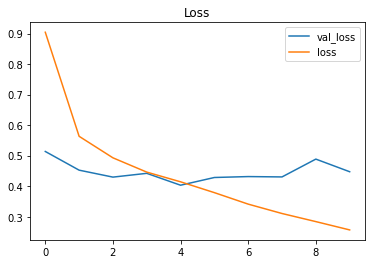

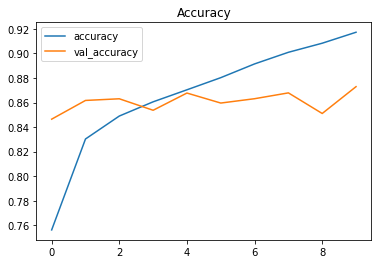

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_1_vals['val_loss'])
plt.plot(model_1_vals['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.show()

plt.plot(model_1_vals['accuracy'])
plt.plot(model_1_vals['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('Accuracy')
plt.show()

In [ ]:
predictions = model.predict(X_test)

In [ ]:
num = 48
output = get_entities(X_test['input_ids'][num], predictions[num], 0.5)
output_comparison = get_entities(X_test['input_ids'][num], y_test[num], 0.5)
output

[['Platiff', 'trump'],
 ['Platiff', 'u . s . civil rights groups'],
 ['Defendant', 'alphabet'],
 ['Defendant', 'youtube'],
 ['Reason', 'it does not remove president donald'],
 ['Reason', "' s channel"],
 ['Reason', 'hate'],
 ['Reason', 'profit'],
 ['Reason', 'youtube take down'],
 ['Reason', "' s"],
 ['Reason', 'youtube channel'],
 ['Reason', 'million subscribers'],
 ['Defendant', 'youtube'],
 ['Reason',
  "removed new content uploaded to president donald trump ' s channel as it violated policies for inciting violence"],
 ['Defendant', 'youtube'],
 ['Defendant', 'facebook'],
 ['Defendant', 'trump'],
 ['Defendant', 'trump'],
 ['Defendant', 'youtube'],
 ['Reason', 'spread of hate'],
 ['Reason', 'hate']]

In [ ]:
output_comparison

[['Defendant', 'chevron'],
 ['Defendant', 'chevron'],
 ['Defendant', 'chevron'],
 ['Platiff', 'cities of san francisco and oakland'],
 ['Defendant', 'five major energy producers'],
 ['Defendant', 'cvx'],
 ['Defendant', 'exxon'],
 ['Defendant', 'conocophillips'],
 ['Defendant', 'shell'],
 ['Reason',
  'accuses five major energy producers - cvx , exxon ( nyse : ) , conocophillips ( nyse : ) , shell ( lon : ) ( rds . a , rds . b ) and - of misleading the public for years about their role in global warming'],
 ['Reason',
  'the cities are seeking an abatement fund to help them address flooding they say is a result of climate change'],
 ['Defendant', 'exxon'],
 ['Defendant', 'chevron']]

In [ ]:
training_data[-1]
text = training_data[-1][0]
for ent in training_data[-1][1]['entities']:
  print(f'{ent[2]} :', text[ent[0]:ent[1]])

Defendant : Amazon
Platiff : Washington, DC's attorney general
Defendant : Amazon.com
Defendant : Amazon
Reason : the online retailer broke antitrust law by requiring that third-party sellers not offer better deals for their products elsewhere
Platiff : Attorney General Karl Racine
Defendant : Amazon
Defendant : Amazon
Defendant : Amazon
Defendant : Amazon
Platiff : DC attorney general
Defendant : Amazon
Defendant : Amazon
Defendant : Amazon
Defendant : Amazon
Reason : used its dominant position in the online retail market to win at all costs. It maximizes its profits at the expense of third-party sellers and consumers, while harming competition
Defendant : Amazon.com


In [ ]:
"""
entity_diction = {
    "Reason":0,
    "Outcome":1,
    "No-Tag":2
}

"""
entity_diction = {
    "Platiff":0,
    "Defendant":1,
    "Reason":2,
    "Penalties":3,
    "Outcome":4,
    "No-Tag":5
}



metrics = {
    
}


predictions = model.predict(X_test)


predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

for key in entity_diction.keys():
  val = entity_diction[key]
  metrics[key] = {'Pred':[],
                  'Actual':[]
                  }
  for i in range(len(X_test['input_ids'])):
    for n in range(len(X_test['input_ids'][i])):
        mask = X_test['attention_mask'][i][n]
        if mask == 1:
            pred = predictions[i][n][val]
            if ~np.isinf(pred):
              if ~np.isnan(pred):
                metrics[key]['Pred'].append(pred)
                metrics[key]['Actual'].append(y_test[i][n][val])



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

outputer = {'Label':[],
            'Accuracy':[],
            'Precision':[],
            'Recall':[],
            'F1 Score':[]}

confusion_matrixs = {}

for key in metrics.keys():
    outputer['Label'].append(key)
    outputer['Accuracy'].append(accuracy_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Precision'].append(precision_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['Recall'].append(recall_score(metrics[key]['Actual'], metrics[key]['Pred']))
    outputer['F1 Score'].append(f1_score(metrics[key]['Actual'], metrics[key]['Pred']))
    confusion_matrixs[key] = confusion_matrix(metrics[key]['Actual'], metrics[key]['Pred'])

In [ ]:
import pandas as pd
df = pd.DataFrame(outputer, columns=['Label', 'Accuracy','Precision', 'Recall', 'F1 Score'])
df

,Label,Accuracy,Precision,Recall,F1 Score
0,Platiff,0.973312,0.649682,0.325100,0.433351
1,Defendant,0.974187,0.663836,0.787322,0.720325
2,Reason,0.906453,0.546778,0.627685,0.584444
3,Penalties,0.995948,0.714286,0.087719,0.156250
4,Outcome,0.964007,0.525547,0.244233,0.333488
5,No-Tag,0.854852,0.918660,0.896774,0.907585


In [ ]:
for key in confusion_matrixs.keys():
  print(key)
  print(confusion_matrixs[key])

Platiff
[[38505   220]
 [  847   408]]
Defendant
[[37619   673]
 [  359  1329]]
Reason
[[33610  2180]
 [ 1560  2630]]
Penalties
[[39803     6]
 [  156    15]]
Outcome
[[38181   325]
 [ 1114   360]]
No-Tag
[[ 5682  2523]
 [ 3280 28495]]


In [ ]:
def inverse_sigmoid(prob):
  return -(np.log((1/prob) - 1))

In [ ]:
prob = 0.8
_X_ = inverse_sigmoid(prob)
_y_ = inverse_sigmoid((1-prob))
print('X = ', inverse_sigmoid(prob))
print('y = ', inverse_sigmoid((1-prob)))

X =  1.3862943611198906
y =  -1.3862943611198908


In [ ]:
def softmax_calc(vals, val):
  
  vals = np.array(vals)
  softmax = np.exp(val)/(np.exp(vals).sum())

  return softmax

In [ ]:
test = [_X_, _y_]
print(softmax_calc(test, _X_))

0.9411764705882353


In [ ]:
new_mod = tf.keras.Model(model.input, model.get_layer('dense_1').output)

ValueError: ignored

In [ ]:
test_output = new_mod.predict(X_test)[2]

In [ ]:
test_z = np.dot(test_output, model.get_layer('dense_2').get_weights()[0])

In [ ]:
test_z

In [ ]:
test = model.predict(X_test)[0]

In [ ]:
new_predict = []

for i in range(len(test_output)):
    new = []
    for n in range(len(test_z[i])):
      zs = softmax_calc(test_z[i],test_z[i][n]) 
      new.append(zs)
    new_predict.append(new)

In [ ]:
roll = 7
new_pred = []
for i in range(len(test_z)):
  if i >= roll:
      back = i - roll
      forward = i + roll
      summary = test_z[back:forward]
      ori = []
      for sum in summary:
          if ori == []:
            ori = sum
          else:
            ori += sum
      ori /= len(summary)
      preds = []
      for val in ori:
        dist = softmax_calc(ori, val)
        preds.append(dist)
      new_pred.append(preds)
      



In [ ]:
new_pred = np.array(new_pred)
new_output = get_entities_argmax_altered(X_test['input_ids'][num], new_pred, 0.5)
new_output

In [ ]:
test_z 